## Introduction

In this notebook I am trying to use img2img pipeline and linear interpolation

## Importing libraries

In [2]:
import torch, logging
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers import StableDiffusionPipeline
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import numpy as np
from torchvision import transforms as tfms
from huggingface_hub import notebook_login
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
logging.disable(logging.WARNING) ## ignore warnings
%matplotlib inline

## Pre loading models

Stable diffusion model depends on three things - 
1. `CLIP model` - For converting promts to a embedding which gives the visual clue
2. `VAE (Variational Auto Encoder)` - To reduce the dimensions of the original image for faster computations
3. `UNET` - The model which takes a noisy i/p and embedded promt to predict the noise present in the i/p

### Importing diffusion UNet and VAE

In [3]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

### CLIP artifacts

In this case, we are using CLIP model which converts the texual prompt into an embedding. To do this using transformers library ,we need two things - 
- 1) `Tokenizer` - This function takes the raw text, breaks it into words and then convert them into numeric forms
- 2) `text_encoder` - This function takes the tokenizer ip and convert them into embeddings

In [4]:
## Loading clip tokenizer and encoder 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

### Scheduler Artifacts

This tells the model on how much noise to add at a given timestep

In [5]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

Text(0.5, 1.0, 'Schedular routine')

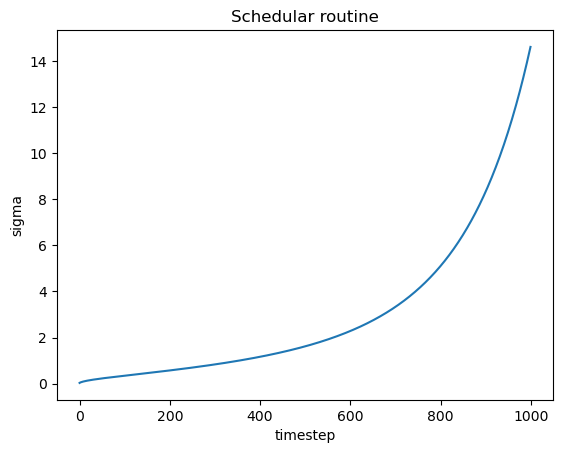

In [6]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])
plt.xlabel("timestep")
plt.ylabel("sigma")
plt.title("Schedular routine")

## Getting base image generated

In [7]:
def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    """
    A function to take the sample and convert it back into the original image
    """
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [8]:
def mk_samples_from_prompt(prompts, neg_prompt=None, g=7.5, seed=100, steps=70, dim=512):
    bs = len(prompts)
    text = text_enc(prompts) 
    if not neg_prompt:
        uncond =  text_enc([""] * bs, text.shape[1])
    else:
        assert len(prompts) == len(neg_prompt)
        uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

  0%|          | 0/70 [00:00<?, ?it/s]

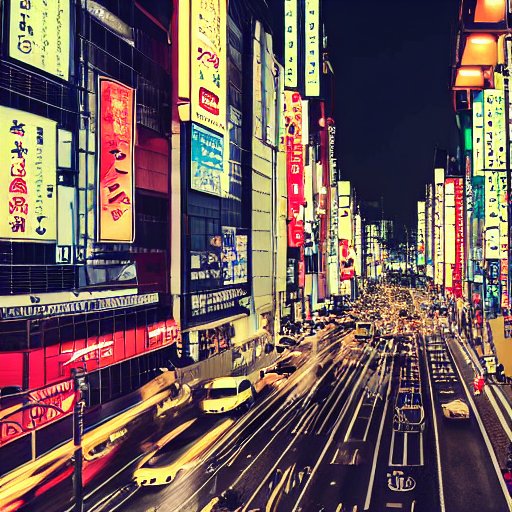

In [82]:
prompts = ["busy streets in night in Tokyo photgraph"]
images = mk_samples_from_prompt(prompts, seed = 1000, steps=70)
for img in images:display(mk_img(img))
mk_img(img).save(f'img/{0:04}.jpeg')

## Passing many prompts and linear interpolation

In [11]:
def load_image(p):
    return Image.open(p).convert('RGB').resize((512,512))
def preprocess(image):
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

In [12]:
def mk_samples_i2i(prompt_emb, init_img, neg_prompt=None, g=7.5, strength =0.8, seed=100, steps=50, dim=512):
    if seed: torch.manual_seed(seed)
    
    # Step 1: Encode text
    text = prompt_emb
    if not neg_prompt:
        uncond =  text_enc([""], text.shape[1])
    else:
        assert len(prompts) == len(neg_prompt)
        uncond =  text_enc(neg_prompt, text.shape[1])
        
    emb = torch.cat([uncond, text])
    
    # Step 2: Initiate scheduler step
    scheduler.set_timesteps(steps)
    
    # Step 3: Covert image to latents
    init_latents = preprocess(init_img) # encoded output from VAE
    
    # Step 4: Figuring initial time step based on strength
    
    init_timestep = int(steps * strength)
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")

    # Step 5: Adding noise to inital image
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Step 6: figuring out the time step to start with
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Step 7: Running diffusion loop
    for i,ts in enumerate(tqdm(timesteps)):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, ts)
        with torch.no_grad():
            u,t = unet(latent_model_input, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample
    
    with torch.no_grad(): 
        return mk_img(vae.decode(1 / 0.18215 * latents).sample[0])

In [91]:
prompts = [
    "busy streets in night in Tokyo photgraph", # 0
    "busy streets in night in Korea photgraph", # 2
    "busy streets in night in Beijing photgraph", # 4
    "busy streets in night in Delhi photgraph", # 6
    "busy streets in night in Paris photgraph", # 8
    "busy streets in night in New York photgraph", # 10
    "busy streets in night in Seattle photgraph" # 12
]

## interpolation scheme generation
encoded_prompts = text_enc(prompts)
new_interpolated_prompts = []                                  
for idx in range(len(prompts)):
    print(idx)
    new_interpolated_prompts.append(encoded_prompts[idx])
    if idx+1 < len(prompts):
        new_interpolated_prompts.append(0.5*encoded_prompts[idx] + 0.5*encoded_prompts[idx+1])
new_interpolated_prompts = torch.stack(new_interpolated_prompts)

0
1
2
3
4
5
6


In [ ]:
## Successive interpotaltion
for idx in tqdm(range(new_interpolated_prompts.shape[0])):
    print(idx)
    image = mk_samples_i2i(
        prompt_emb = new_interpolated_prompts[idx,:,:].unsqueeze(0), 
        init_img = load_image(f"./img/{idx:04}.jpeg"),
        g=7.5,
        strength=0.8,
        steps=70,
        seed=1000
    )
    image.save(f"img/{idx+1:04}.jpeg")

In [ ]:
!ffmpeg -v 1 -y -f image2 -framerate 2 -i img/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out2.mp4

In [ ]:
!ffmpeg -i img/output/out2.mp4 -r 2 -s 512x512 img/output/output2.gif -y

In [94]:
## Fixed interpotaltion
for idx in tqdm(range(new_interpolated_prompts.shape[0])):
    print(idx)
    image = mk_samples_i2i(
        prompt_emb = new_interpolated_prompts[idx,:,:].unsqueeze(0), 
        init_img = load_image(f"./img/{0:04}.jpeg"),
        g=7.5,
        strength=0.8,
        steps=70,
        seed=1000
    )
    image.save(f"img/{idx+1:04}.jpeg")

  0%|          | 0/13 [00:00<?, ?it/s]

0


  0%|          | 0/56 [00:00<?, ?it/s]

1


  0%|          | 0/56 [00:00<?, ?it/s]

2


  0%|          | 0/56 [00:00<?, ?it/s]

3


  0%|          | 0/56 [00:00<?, ?it/s]

4


  0%|          | 0/56 [00:00<?, ?it/s]

5


  0%|          | 0/56 [00:00<?, ?it/s]

6


  0%|          | 0/56 [00:00<?, ?it/s]

7


  0%|          | 0/56 [00:00<?, ?it/s]

8


  0%|          | 0/56 [00:00<?, ?it/s]

9


  0%|          | 0/56 [00:00<?, ?it/s]

10


  0%|          | 0/56 [00:00<?, ?it/s]

11


  0%|          | 0/56 [00:00<?, ?it/s]

12


  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
!ffmpeg -v 1 -y -f image2 -framerate 2 -i img/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out3.mp4

In [16]:
!ffmpeg -i img/output/out3.mp4 -r 2 -s 512x512 img/output/output3.gif -y

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/aayush/miniconda3/envs/fastai --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc  

In [50]:
text_list = ['Original', 'Tokyo', 'Tokyo+Korea', 'Korea', 'Korea+Beijing', 'Beijing', 'Beijing+Delhi', 'Delhi', 'Delhi+Paris', 'Paris', 'Paris+New York', 'New York',  'New York+Seattle', 'Seattle']

14

In [117]:
font_type = ImageFont.truetype("Arial.ttf", 18)
for idx, text in enumerate(text_list):
    img = load_image(f"./img/{idx:04d}.jpeg")
    I1 = ImageDraw.Draw(img)
    I1.text((0, 0), text,font=font_type, fill=(255, 0, 0))
    img.save(f"img/{idx:04}.jpeg")

In [ ]:
!ffmpeg -v 1 -y -f image2 -framerate 2 -i img/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out4.mp4

In [17]:
!ffmpeg -i img/output/out4.mp4 -r 2 -s 512x512 img/output/output4.gif -y

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/aayush/miniconda3/envs/fastai --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc  